# 1. Install and import dependencies

Перед тем как начать работу, необходимо подготовить окружение, для автоматического сопоставления версий пакетов:

```bash
conda create --name env_pt python=3.10
conda activate env_pt

```

Далее установим PyTorch с поддержкой CUDA, в данном случае будет использоваться версия `pytorch-cuda=11.8`. После установке выполним проверку того, что все пакеты были успешно установлены:

```bash
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
conda list torch
```
*здесь автоматически установится необходимая версия NumPy

В качестве алгоритма обучения с подкреплением, будет использоваться Stable Baselines3 (SB3):

```bash
conda install conda-forge::stable-baselines3
```

Pytesseract — это обертка для инструмента OCR (распознавания текста) под названием Tesseract, разработанного Google. Эта библиотека позволяет извлекать текст из изображений.

```bash
conda install conda-forge::pytesseract
```

Чтобы воспроизвести функциональность ввода с помощью мыши и клавиатуры, установим библиотеку PyDirectInput, которая является более быстрым аналогом PyAutoGUI:

```bash
conda install pydirectinput
```

Далее установим MSS (Multiple Screen Shots) — это библиотека для захвата скриншотов. Будем использовать именно её, так как она легко интегрируется с opencv:

```bash
conda install python-mss
```

Установим остальные библиотеки:

```bash
conda install opencv matplotlib gym
```

In [27]:
from debugpy.launcher import channel
from gitdb.util import close
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete  # для определения типа входных данных (изображения) и действий в RL Environment

# 2. Настройка окружения

## 2.1. Создание окружения

In [28]:
class WebGame(Env):
    def __init__(self):  # Все переменные окружения, как выглядит само окружение и тд
        super().__init__()  
        # Установка пробелов
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        self.cap = mss()  # получение снимка экрана
        # Установим область, чтобы захватывалось только игровое пространство
        self.game_location = {'top': 300, 'left':400, 'width':800, 'height':400}
        self.done_location = {'top': 375, 'left':920, 'width':720, 'height':65}
        
    def step(self, action):  # Что именно вызывается, чтобы что-то произошло в окружении
        # Action key - 0 = Space, 1 = Duck(down), 2 = No action (no_op)
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
            
        # Проверка на то, что игра закончена
        done = self.get_done()
        # Получение нового кадра = нового состояния
        new_observation = self.get_observation()
        
        # Награда - получение 1 очка за каждый кадр, пока игра не закончена, т.е. Динозавр жив
        reward = 1
        # Info dictionary
        info = {}
        
        return new_observation, reward, done, info
    
    def reset(self):  # Перезапуск игры
        time.sleep(1)
        pydirectinput.click(x=475+40, y=1240+35)
        pydirectinput.press('space')
        return self.get_observation()
    
    def render(self):  # Визуализация процесса
        frame = self.get_observation()
        cv2.imshow('Game', frame[0])  # `frame[0]` to match shape (1, 83, 100)
        if cv2.waitKey(1) & 0xFF == (ord('q') or ord('й')):
            self.close()
        
    def close(self):  # закрыть наблюдение
        cv2.destroyAllWindows()
    
    def get_observation(self):  # Получить ту часть, которую может наблюдать агент, в данном случае, динозавр
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (200, 100))
        # Add channels first
        channel = np.reshape(resized, (1, 100, 200))
        
        return channel
    
    def get_done(self):  # display GameOver screen
        # get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        # Valid done text "chrome enterprise"
        done_strings = ['GAME', 'GANE', 'chro', 'ohro', 'cno', 'ono']
        
        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap, lang='eng')[:4]
        if res in done_strings:
            done = True
        
        return done

Получим снимок экрана для конкретной области

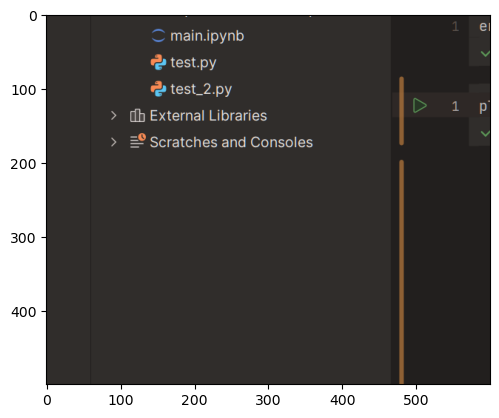

In [48]:
env = WebGame()
plt.imshow(env.get_observation())

In [6]:
env = WebGame()
env.get_observation().shape

(1, 83, 100)

Теперь перейдём на необходимый экран и сделаем снимок там:

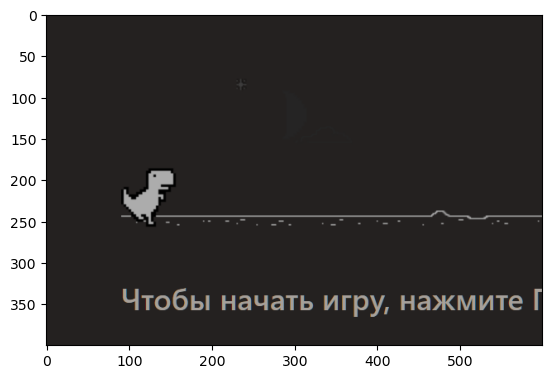

In [83]:
plt.imshow(env.get_observation())

Установим параметры, чтобы отображалась только интересующая нас область:

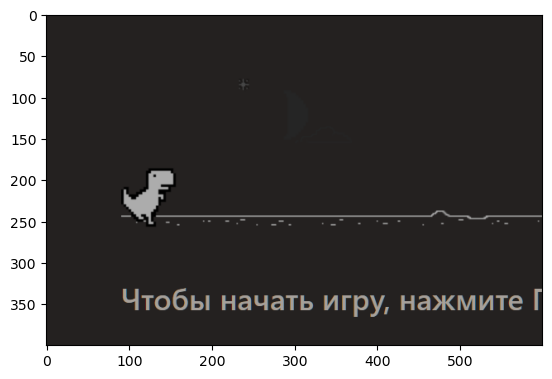

In [64]:
plt.imshow(env.get_observation())

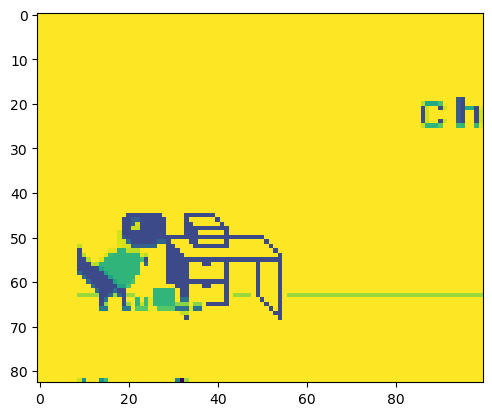

In [127]:
env = WebGame()
plt.imshow(env.get_observation()[0])

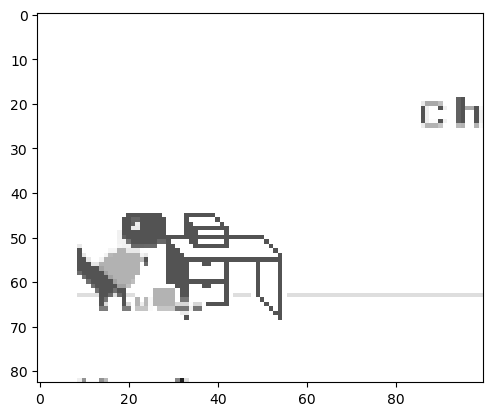

In [141]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

(65, 720, 3)
True
GAME


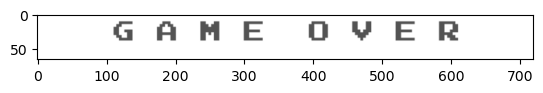

In [37]:
res, done, done_cap = WebGame().get_done()
print(done_cap.shape)  # Game over cap shape
print(done)  # Game over text detected
print(res)  # First four letters
plt.imshow(done_cap)

(65, 720, 3)
True
chro


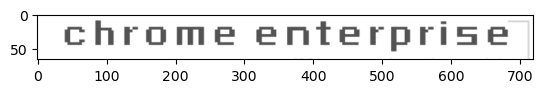

In [36]:
res, done, done_cap = WebGame().get_done()
print(done_cap.shape)  # Game over cap shape
print(done)  # Game over text detected
print(res)  # First four letters
plt.imshow(done_cap)

In [46]:
env = WebGame()

In [35]:
env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [17]:
env.render()

In [18]:
env.close()

## 2.2. Тестирование окружения

In [29]:
env = WebGame()

In [52]:
obs = env.get_observation()

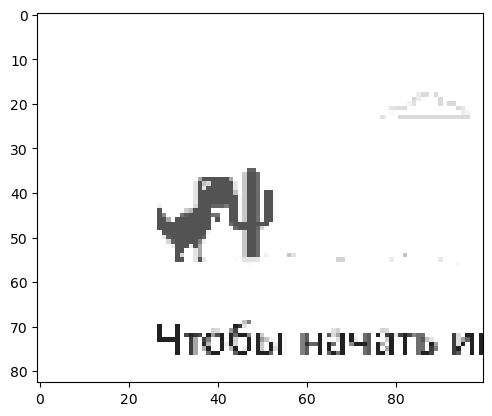

In [49]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [62]:
_, done, done_cap = env.get_done()
print(done)

True


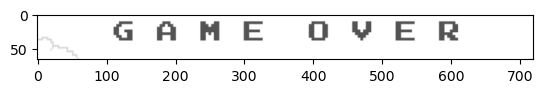

In [63]:
plt.imshow(done_cap)

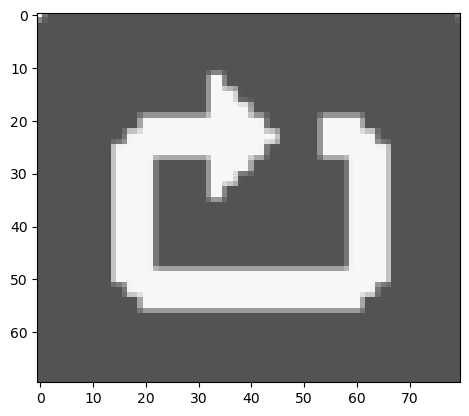

In [119]:
env = WebGame()
_, done, done_cap = env.get_done()
plt.imshow(done_cap)

In [66]:
pytesseract.image_to_string(done_cap, lang='eng')[:4]

'GAME'

In [32]:
env = WebGame()

for episode in range(10):  # Запуск 10 игр
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done: 
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total reward for episode {episode} is {total_reward}')

Total reward for episode 0 is 19
Total reward for episode 1 is 33
Total reward for episode 2 is 22
Total reward for episode 3 is 17
Total reward for episode 4 is 14
Total reward for episode 5 is 21
Total reward for episode 6 is 26
Total reward for episode 7 is 17
Total reward for episode 8 is 16
Total reward for episode 9 is 25


  ## 3. Тренировка модели

 ## 3.1. Создание callback'а

In [33]:
import os 
# Используем Base Callback для сохранения моделей
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [34]:
env_checker.check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/